In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing as skp 
import utils as ut
import netutils as net

In [2]:
# Let us read the logs into the various files 
# For each log, we will map source and destinations IP to local IPV4 format. 
# To do this, we define a new routine that uses the mapping_dict stored to do the mappings 

mapping_dict=ut.read_as_dict('unsw/mapping.csv','Original','Mapped')
conn_df = net.read_n_map('unsw/day_logs/conn.log', mapping_dict)

#Let us read the http and dns logs 
http_df = net.read_n_map('unsw/day_logs/http.log', mapping_dict)
dns_df = net.read_n_map('unsw/day_logs/dns.log', mapping_dict)

In [3]:
# Let us read the data-frames so that they mapped to hourly boundaries 
# These files are generated in Australia on a daily boundary, so we will use that 
# time-zone to divide the files into chunks from 0-24. 
# We do this by adding an hour field to the various data_frames 
HOUR='Hour'

conn_df = net.add_hour(conn_df, field_name=HOUR, local_prefix='192.168.1')
dns_df = net.add_hour(dns_df, field_name=HOUR,local_prefix='192.168.1')
http_df = net.add_hour(http_df, field_name=HOUR,local_prefix='192.168.1')

#We will also exclude the router from the requests. 
conn_df = conn_df[conn_df[net.SRC_IP]!='192.168.1.1']

In [4]:
#Let us also add the device type for the known devices in the data set. 
#The ground truth file has this list of devices. 

DEV_TYPE='DevType'
UNKNOWN='Unkown'
def add_devtype(df, map_dict, field_name):
    return ut.add_column(df, map_dict, field_name, orig_column=net.SRC_IP, default_value=UNKNOWN)

 
map_dict = ut.read_as_dict('unsw/ground_truth.csv', 'SrcIPAddress', 'Types')
conn_df = add_devtype(conn_df, map_dict, DEV_TYPE)
http_df = add_devtype(http_df, map_dict, DEV_TYPE)
dns_df = add_devtype(dns_df, map_dict, DEV_TYPE)

In [5]:
dns_df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,rtt,query,...,AA,TC,RD,RA,Z,answers,TTLs,rejected,Hour,DevType
0,1.474726e+09,Cmq5BD4abGJE9M6Dn6,192.168.1.166,45136,192.168.1.1,53,udp,31287,0.284601,babyws.withings.net,...,False,False,True,True,0,[89.30.121.150],[600.0],False,0,IoT
1,1.474726e+09,CqS2E81hhnbbAo7xH9,192.168.1.120,37616,192.168.1.1,53,udp,379,0.000366,sip.invoxia.com,...,False,False,True,True,0,[46.105.38.79],[602.0],False,0,IoT
2,1.474726e+09,CLGxUt3vdwASMqHn66,192.168.1.196,4355,192.168.1.1,53,udp,159,0.004368,pool.ntp.org,...,False,False,True,True,0,"[27.124.125.250, 129.250.35.251, 202.60.94.15,...","[56.0, 56.0, 56.0, 56.0]",False,0,IoT
3,1.474726e+09,C3R8kh48F3GhWB5y4c,192.168.1.249,43171,192.168.1.1,53,udp,16295,0.021244,www.samsungsmartcam.com,...,False,False,True,True,0,"[www.samsungsmartcam.com.edgekey.net, e6081.b....","[60.0, 4631.0, 20.0]",False,0,IoT
4,1.474726e+09,C3R8kh48F3GhWB5y4c,192.168.1.249,43171,192.168.1.1,53,udp,16295,0.000324,www.samsungsmartcam.com,...,False,False,True,True,0,"[www.samsungsmartcam.com.edgekey.net, e6081.b....","[55.0, 4626.0, 15.0]",False,0,IoT


In [6]:
# Let us aggregate the features for each SRC_IP address by hours
# Each feature would have the fields - SRC_IP, HOUR, AVG_VALUES
BYTES_OUT='BytesOut'
BYTES_IN='BytesIn'
PEERS='Peers'
COUNT='Count'
URI_PEERS='URI_Peers'
PAGE_SIZE='PageSize'

conn_agg_dict = { net.PAYLOAD_BYTES_OUT: 'mean',
             net.PAYLOAD_BYTES_IN: 'mean',
             net.DEST_IP: 'nunique',
             net.DEST_PORT: 'count'      
           }

conn_renamer = {
    net.PAYLOAD_BYTES_OUT: BYTES_OUT,
    net.PAYLOAD_BYTES_IN: BYTES_IN,
    net.DEST_IP: PEERS,
    net.DEST_PORT: COUNT
}

http_agg_dict = { net.HTTP_URI: 'nunique', 
                 net.HTTP_RSP_SIZE: 'mean' 
                }
http_renamer = { net.HTTP_URI: URI_PEERS, 
                net.HTTP_RSP_SIZE: PAGE_SIZE 
               }


In [7]:
def create_agg_features(df, feature_list, agg_dict, renamer=None, add_type=False, map_dict=None):
    features = df.groupby(feature_list).agg(agg_dict).reset_index()
    if add_type and map_dict is not None: 
        features = add_devtype(features, map_dict, DEV_TYPE)
    if renamer is not None:
        features= features.rename(mapper=renamer, axis=1)
    return features.dropna()

conn_features = create_agg_features(ut.filter_df(conn_df,DEV_TYPE,UNKNOWN), [net.SRC_IP, HOUR], conn_agg_dict, conn_renamer,True, map_dict)
http_features = create_agg_features(ut.filter_df(http_df,DEV_TYPE,UNKNOWN), [net.SRC_IP, HOUR], http_agg_dict, http_renamer,True, map_dict)
dns_features = create_agg_features(ut.filter_df(dns_df,DEV_TYPE,UNKNOWN), [net.SRC_IP, HOUR], {net.DNS_QUERY:'nunique'}, None, True, map_dict)


In [8]:
dns_features.head()

,id.orig_h,Hour,query,DevType
0,192.168.1.112,0,1,IoT
1,192.168.1.112,1,1,IoT
2,192.168.1.112,2,1,IoT
3,192.168.1.112,3,1,IoT
4,192.168.1.112,4,1,IoT


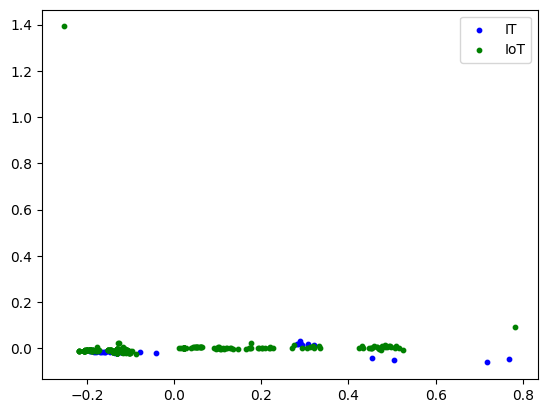

In [9]:
ut.plot_pca_map(conn_features, [BYTES_OUT, BYTES_IN, PEERS, COUNT], DEV_TYPE)

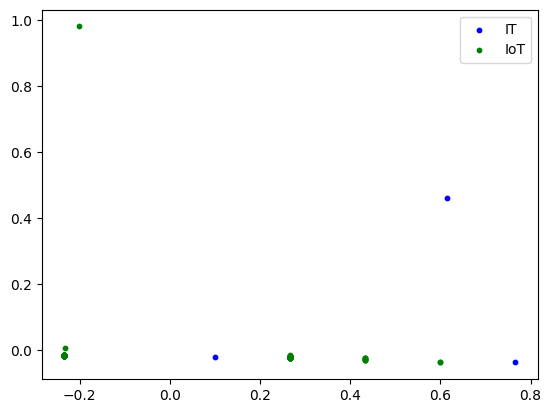

In [10]:
ut.plot_pca_map(http_features, [URI_PEERS, PAGE_SIZE], DEV_TYPE)

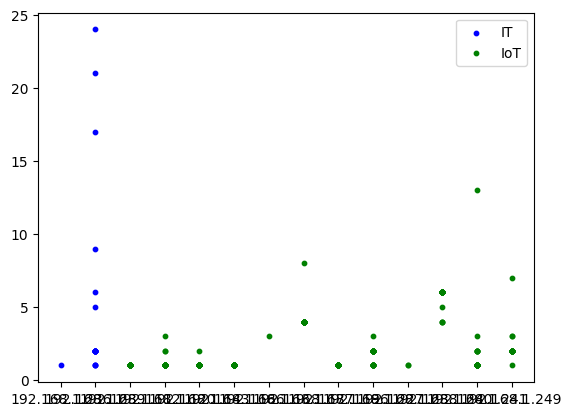

In [11]:
ut.plot_df(dns_features, net.SRC_IP, net.DNS_QUERY, DEV_TYPE)

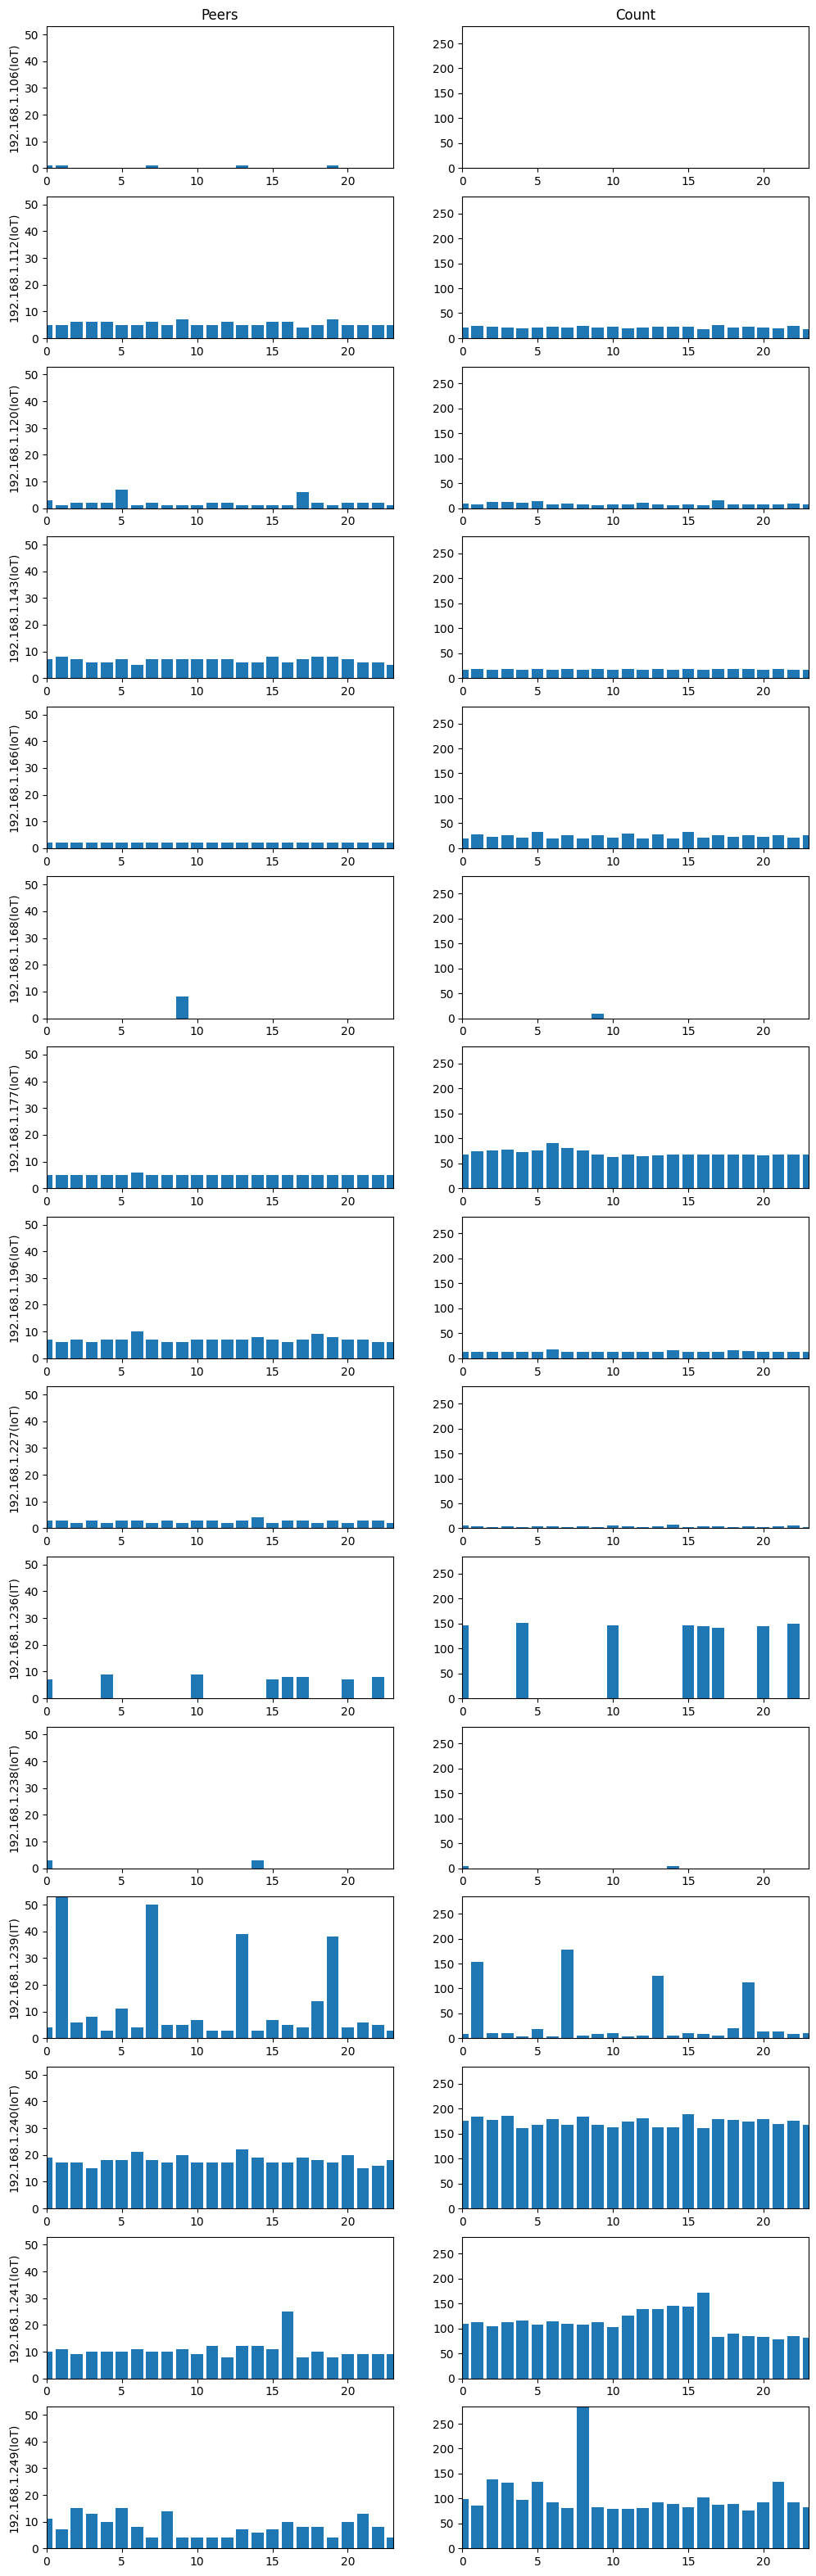

In [12]:
selectors = [net.SRC_IP, HOUR, DEV_TYPE,PEERS,COUNT]                
ut.plot_multi_bar(conn_features[selectors], net.SRC_IP, HOUR,DEV_TYPE, figsize=(12,40))

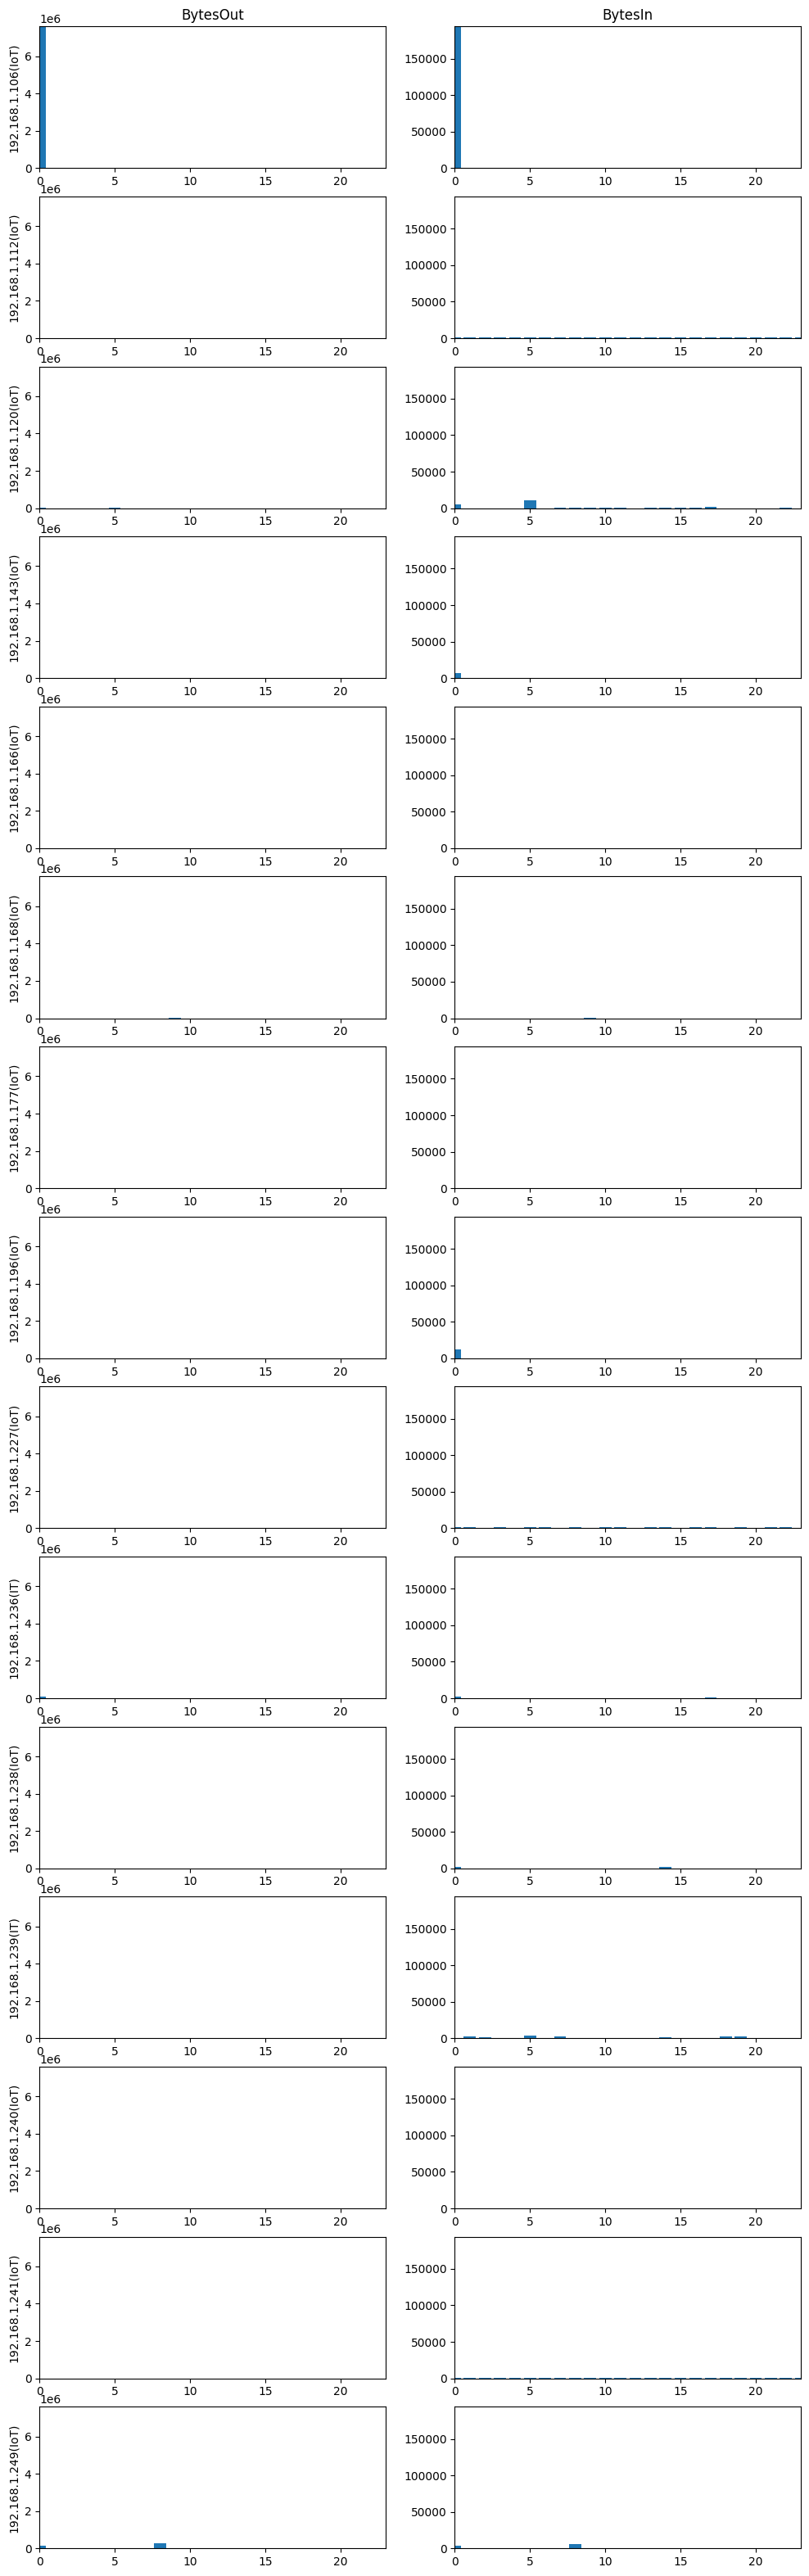

In [13]:
selectors = [net.SRC_IP, HOUR, DEV_TYPE,BYTES_OUT,BYTES_IN]                
ut.plot_multi_bar(conn_features[selectors], net.SRC_IP, HOUR,DEV_TYPE, figsize=(12,40))

In [14]:
# Let us now train the test_df and train_df 
# We will uses hours 0..n to train a classifier for IoT vrs IT 
# Then we will use hours n+1... as test data set. 

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as skm 

def time_based_traintest_split(df, train_hours,only_next_hour=True):
    train_df = df[df[HOUR]<train_hours]
    features = [x for x in list(df.columns) if x not in [net.SRC_IP, DEV_TYPE,HOUR]]
    train_X = train_df[features].to_numpy()
    train_Y = train_df[DEV_TYPE].to_list()
    
    if only_next_hour:
        test_df = df[df[HOUR]==train_hours]
        test_X = test_df[features].to_numpy()
        test_Y = test_df[DEV_TYPE].to_list()
        labels = test_df[net.SRC_IP].to_list() 
        return train_X, train_Y, test_X, test_Y, labels
    else:
        test_X = list()
        test_Y = list()
        labels = list()
        for hr in range(train_hours, df[HOUR].max()):
            test_df = df[df[HOUR]==hr]
            test_X.append(test_df[features].to_numpy())
            test_Y.append(test_df[DEV_TYPE].to_list())  
            labels.append(test_df[net.SRC_IP].to_list())
        return train_X, train_Y, test_X, test_Y, labels

def train_pipeline(train_X, train_Y):
    myfunctions = [('PreProcess', skp.MinMaxScaler()), ('Classifier', RandomForestClassifier() )]
    pipeline = Pipeline(myfunctions)
    pipeline.fit(train_X, train_Y)
    return pipeline
    
    
def single_evaluate(train_X, train_Y,test_X, test_Y, labels):
    pipeline = train_pipeline(train_X, train_Y)
    pred = pipeline.predict(test_X)                      
    wrong_ones = [x for i,x in enumerate(labels) if pred[i] != test_Y[i]]
    return skm.f1_score(test_Y, pred, average="micro"), wrong_ones
    

def next_hr_evaluate(df, train_hours):
    train_X, train_Y, test_X, test_Y,labels = time_based_traintest_split(df, train_hours,True)
    return single_evaluate(train_X, train_Y,test_X, test_Y,labels)
    
def display_metrics(metrics):
    scores = [x[0] for x in metrics]
    ut.plot_bar(range(0,len(metrics)), scores, 'hours', 'F1-Score')
    
def display_mistakes(metrics):
    missed = [len(x[1]) for x in metrics]
    ut.plot_bar(range(0,len(metrics)), missed, 'hours', 'missed')

def print_mistakes(metrics):
    missed = [x[1] for x in metrics]
    for i, x in enumerate(missed): 
        missed = [len(x[1]) for x in metrics]
        print(f'{i}: {len(x)} Identity: {list(set(x))}')


In [15]:
conn_metrics = [next_hr_evaluate(conn_features, hour) for hour in range(1,24)]
http_metrics = [next_hr_evaluate(http_features, hour) for hour in range(1,24)]
dns_metrics = [next_hr_evaluate(dns_features, hour) for hour in range(1,24)]

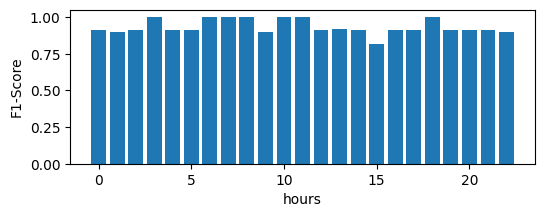

In [16]:
# display_metrics(conn_metrics)
# display_metrics(http_metrics)
display_metrics(dns_metrics)

In [17]:
# print_mistakes(conn_metrics)
# print_mistakes(http_metrics)
# print_mistakes(dns_metrics)

In [18]:
def all_hr_evaluate(df, train_hours):
    train_X, train_Y, test_X, test_Y,labels = time_based_traintest_split(df, train_hours,False)
    answer = list()
    for i in range(len(test_X)):
        this_X = test_X[i]
        this_Y = test_Y[i]
        this_labels = labels[i]
        score, mistakes = single_evaluate(train_X, train_Y,this_X, this_Y,this_labels)
        answer.append((score, mistakes))
    return answer

def display_all_hr_metrics(metrics):
    scores = [x[0] for x in metrics]
    ut.plot_bar(range(0,len(metrics)), scores, 'hours', 'F1-Score')


In [19]:
# all_metrics = all_hr_evaluate(conn_features, 5)
#all_metrics = all_hr_evaluate(http_features, 5)
all_metrics = all_hr_evaluate(dns_features, 5)
for i,x in enumerate(all_metrics):
    print(f'Post Training Hour:{i} Score: {x[0]:.2f} Wrong Ones: {x[1]}')

Post Training Hour:0 Score: 0.91 Wrong Ones: ['192.168.1.239']
Post Training Hour:1 Score: 0.91 Wrong Ones: ['192.168.1.239']
Post Training Hour:2 Score: 1.00 Wrong Ones: []
Post Training Hour:3 Score: 1.00 Wrong Ones: []
Post Training Hour:4 Score: 1.00 Wrong Ones: []
Post Training Hour:5 Score: 0.90 Wrong Ones: ['192.168.1.239']
Post Training Hour:6 Score: 1.00 Wrong Ones: []
Post Training Hour:7 Score: 1.00 Wrong Ones: []
Post Training Hour:8 Score: 0.91 Wrong Ones: ['192.168.1.239']
Post Training Hour:9 Score: 0.92 Wrong Ones: ['192.168.1.239']
Post Training Hour:10 Score: 0.91 Wrong Ones: ['192.168.1.239']
Post Training Hour:11 Score: 0.91 Wrong Ones: ['192.168.1.239']
Post Training Hour:12 Score: 0.91 Wrong Ones: ['192.168.1.236']
Post Training Hour:13 Score: 0.91 Wrong Ones: ['192.168.1.239']
Post Training Hour:14 Score: 1.00 Wrong Ones: []
Post Training Hour:15 Score: 0.91 Wrong Ones: ['192.168.1.239']
Post Training Hour:16 Score: 0.91 Wrong Ones: ['192.168.1.239']
Post Trainin

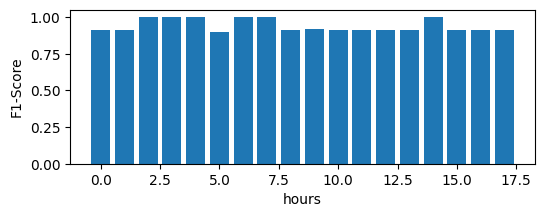

In [20]:
display_all_hr_metrics(all_metrics)

In [21]:
print(conn_features[DEV_TYPE].unique())

['IoT' 'IT']


In [22]:
# Remember, we have two mystery devices -- 192.168.1.193 and 192.168.1.223
# It would be useful to see what the prediction is for those devices using our classifier. 



def mystery_train_set(df, train_hours):
    train_df = df[df[HOUR]<train_hours]
    features = [x for x in list(df.columns) if x not in [net.SRC_IP, DEV_TYPE,HOUR]]
    train_X = train_df[features].to_numpy()
    train_Y = train_df[DEV_TYPE].to_list()
    return train_X, train_Y, features

def create_mystery_features(df, train_hours, device_id, agg_dict, renamer=None):
    # Note that here we need to start from <proto>_df instead of <proto>_features
    sub_df = df[df[net.SRC_IP]==device_id]
    sub_df = sub_df[sub_df[HOUR]>=train_hours]
    #Now, we can do the aggregation -- except for the mapping portion 
    features = create_agg_features(sub_df, [net.SRC_IP, HOUR], agg_dict, renamer, False, None)
    return features

def mystery_test_set(df, hour, features):
    sub_df = df[df[HOUR]==hour]
    return sub_df[features].to_numpy()
    
    
def predict_mystery_device(raw_df, features_df, train_hours, device_id, agg_dict, renamer):
    train_X, train_Y, features = mystery_train_set(features_df, train_hours)
    pipeline = train_pipeline(train_X, train_Y)
    test_features = create_mystery_features(raw_df, train_hours, device_id, agg_dict, renamer)
    test_X_list = [mystery_test_set(test_features,hour, features) for hour in range(train_hours, 23)]
    predictions = [pipeline.predict(test_X)[0] for test_X in test_X_list if test_X.shape[1] > 0]
    return predictions

In [23]:
unknown_id = '192.168.1.193'
#unknown_id = '192.168.1.223'
pred = predict_mystery_device(conn_df, conn_features, 4, unknown_id, conn_agg_dict, conn_renamer)  
print(pred)
pred = predict_mystery_device(http_df, http_features, 4, unknown_id, http_agg_dict, http_renamer)  
print(pred)
pred = predict_mystery_device(dns_df, dns_features, 4, unknown_id, {net.DNS_QUERY:'nunique'}, None)  
print(pred)

['IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT']
['IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT']
['IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT', 'IoT']


In [24]:
def get_feature_importance(df):
    features = [x for x in list(df.columns) if x not in [net.SRC_IP, DEV_TYPE,HOUR]]
    X = df[features].to_numpy()
    Y = df[DEV_TYPE].to_list()
    answer = ut.determine_feature_importance(X,Y,features)
    for x in answer: 
        print(f'{x[0]} : {x[1]:.2f}')  

In [25]:
get_feature_importance(conn_features)
print('******')
get_feature_importance(http_features) 
print('******')
get_feature_importance(dns_features) 

Peers : 0.32
BytesIn : 0.25
BytesOut : 0.25
Count : 0.19
******
PageSize : 0.62
URI_Peers : 0.38
******
query : 1.00


In [26]:
# Now we should want to understand what the tree rules are all about. 
# Since all the features are numeric, we can train a decision tree and see what human readable rules are: 

from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.tree import _tree

def get_tree(df,features,Y_col,max_depth):
    X = df[features].to_numpy()
    Y = df[Y_col].to_list()
    ''' Constraining the tree to maximum depth and also less than 2^features leaf nodes for compact trees'''
    myfunctions = [('PreProcess', skp.MinMaxScaler()), ('Classifier', DecisionTreeClassifier(max_depth=max_depth,max_leaf_nodes=2**X.shape[1] ) )]
    pipeline = Pipeline(myfunctions)
    pipeline.fit(X, Y)
    classifier = pipeline['Classifier']
    return classifier

def print_rules(classifier):
    text_representation = tree.export_text(classifier,feature_names=features)
    print(text_representation)

NAME = 'name'
OP = 'op'
VALUE = 'value'

def consolidate(path:list):
    subset = path[0:-1]
    queries = [x[NAME] for x in subset]
    term_list = list(set(queries))
    answer = list()
    for term in term_list:
        matches = [x for x in subset if x[NAME]==term]
        lower_limit = min([x[VALUE] for x in matches if '<=' == x[OP]] + [10])
        upper_limit = max([x[VALUE] for x in matches if '>' == x[OP]] + [-10])
        if 10 == lower_limit and -10 == upper_limit:
            continue 
        elif 10 == lower_limit: 
            answer.append(f'{term} > {upper_limit}')
        elif -10 == upper_limit:
            answer.append(f'{term} <= {lower_limit}')
        else:
            answer.append(f'{lower_limit} <= {term} < {upper_limit}')
    return answer + [path[-1]]

def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [{ NAME:name, OP:'<=', VALUE: np.round(threshold,2)}]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [{ NAME:name, OP:'>', VALUE: np.round(threshold,2)}]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []

    for path in paths:
        npath = consolidate(path)
        rule = "if "
        
        for p in npath[:-1]:
            if rule != "if ":
                rule += " and "
            rule += p
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

def print_equiv(df):
    features = [x for x in list(df.columns) if x not in [net.SRC_IP, DEV_TYPE,HOUR]]
    this_tree=get_tree(df,features,DEV_TYPE,max_depth=10)
    #print_rules(this_tree)
    rules = get_rules(this_tree,features,this_tree.classes_)
    for this_rule in rules:
        print(this_rule)
    #print(rules)

print_equiv(dns_features)

if query <= 0.33 then class: IoT (proba: 93.98%) | based on 249 samples
if query > 0.33 then class: IT (proba: 80.0%) | based on 5 samples
